In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load wine data
wine_data = pd.read_csv("wine.csv")

# Load salary data
salary_data = pd.read_csv("salary.csv")

In [3]:
# Drop 'Customer_Segment' column
wine_data = wine_data.drop('Customer_Segment', axis=1)

In [4]:
# Check for missing values and drop rows with any missing values
wine_data.dropna(inplace=True)
salary_data.dropna(inplace=True)

In [5]:

def calculate_statistics(data):
    """
    Calculates various statistics for the dataset.
    
    Parameters:
        data (DataFrame): Input DataFrame.
        
    Returns:
        dict: Dictionary containing calculated statistics.
    """
    median_value = data.median()
    skewness = data.skew()
    kurtosis = data.kurt()
    
    statistics = {
        'Median': median_value,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Description': data.describe()
    }
    return statistics

def display_statistics(statistics):
    """
    Displays the calculated statistics.
    
    Parameters:
        statistics (dict): Dictionary containing calculated statistics.
    """
    for stat_name, stat_values in statistics.items():
        print(f"----- {stat_name} -----")
        if stat_name == 'Description':
            print(stat_values)
        else:
            print(stat_values)

def plot_histograms(data):
    """
    Plots histograms for all variables in the dataset.
    
    Parameters:
        data (DataFrame): Input DataFrame.
    """
    plt.figure(figsize=(12, 8))
    palette = sns.color_palette("hsv", len(data.columns))
    for i, col in enumerate(data.columns, start=1):
        plt.subplot(5, 3, i)
        sns.histplot(data[col], color=palette[i-1], kde=True)
        plt.title(f'Histogram of {col}', fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_boxplots(data):
    """
    Plots boxplots after applying log transformation.
    
    Parameters:
        data (DataFrame): Input DataFrame.
    """
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=np.log1p(data), orient='h')
    plt.title('Boxplots of Wine Data Variables', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Log Scale')
    plt.show()

def plot_correlation_matrix(data):
    """
    Plots the correlation matrix.
    
    Parameters:
        data (DataFrame): Input DataFrame.
    """
    plt.figure(figsize=(10, 8))
    corr_matrix = data.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='viridis', annot=True, fmt='.2f')
    plt.title('Correlation Matrix', fontsize=12)
    plt.show()

#Clustering
#Feature Reduction
def perform_pca(data):
    """
    Performs Principal Component Analysis (PCA) and plots the PCA scatter plot.
    
    Parameters:
        data (DataFrame): Input DataFrame.
    """
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)
    data_pca_df = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', data=data_pca_df)
    plt.title('PCA Scatter Plot', fontsize=12)
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.show()


def find_cluster(data):
    """
    Finds number of clusters by elbow method and silhouette method
    """
    # Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    #feature reduction
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)
    data_pca = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])

    # Elbow Method to find optimal number of clusters
    wcss = []
    best_n_clusters, best_silhouette_score = None, -np.inf
    silhouette_scores = []
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data_pca)
        wcss.append(kmeans.inertia_)
        cluster_labels = kmeans.fit_predict(data_pca)
        silhouette_avg = silhouette_score(data_pca, cluster_labels)
        print(f"{n_clusters} Clusters - Silhouette Score: {silhouette_avg:.4f}")
        silhouette_scores.append(silhouette_avg)
        if silhouette_avg > best_silhouette_score:
            best_n_clusters = n_clusters
            best_silhouette_score = silhouette_avg

    
    print(f"Best Number of Clusters: {best_n_clusters} (Silhouette Score: {best_silhouette_score:.4f})")
    # Plot Elbow Method
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, 11), wcss, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within Cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.grid(True)
    plt.show()

def perform_kmeans(data):
    """
    Performs K-Means clustering and plots the K-Means clustering plot.
    
    Parameters:
        data (DataFrame): Input DataFrame.
    """
    # Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    #feature reduction
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)
    data_pca = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])


    # Fit K-Means with optimal number of clusters
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(data_scaled)

    # Add cluster labels to the PCA DataFrame
    data_pca['Cluster_Labels'] = kmeans.labels_
    # Get centroids
    centroids = pca.transform(kmeans.cluster_centers_)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster_Labels', palette='cool', data=data_pca)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='black', label='Centroids')
    plt.title('K-Means Clustering Plot', fontsize=12)
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.legend(title='Cluster Labels')
    plt.show()

def line_plot(data):
    """
    Create a line plot to show the trend of the data
        
    Parameters:
        data (DataFrame): Input DataFrame.
    """
    # Create the plot for salary data
    plt.figure(figsize=(10, 6))
    plt.plot(data['YearsExperience'], data['Salary'], marker='o', linestyle='-', color='b')
    plt.xlabel('Years of Experience')
    plt.ylabel('Salary')
    plt.title('Salary vs. Years of Experience')
    plt.xticks(np.arange(0, 16, 2.5))  
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def exponential_fit(data):
    """
    Create a exponential fit to the line plot of the original data and predicts future values
        
    Parameters:
        data (DataFrame): Input DataFrame.
    """
    # Exponential function
    def exponential_function(x, a, b):
        return a * np.exp(b * x)

    # Fit the exponential curve
    exponential_params, exponential_covariance = curve_fit(exponential_function, data['YearsExperience'], data['Salary'])
    a, b = exponential_params
    
    # Predict salaries for 20 years of experience
    years_of_exp = np.arange(0, 20.1, 0.1)
    exponential_predictions = exponential_function(years_of_exp, a, b)
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(data['YearsExperience'], data['Salary'], marker='o', linestyle='-', color='cyan',label = "Original Data")
    plt.plot(years_of_exp, exponential_predictions, label='Exponential Fit', linestyle='--')
    plt.xlabel('Years of Experience')
    plt.ylabel('Salary')
    plt.title('Salary Prediction with Exponential Fits')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def perform_linear_regression(data):
    """
    Performs linear regression and plots the regression line.
    
    Parameters:
        data (DataFrame): Input DataFrame.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(data['YearsExperience'], data['Salary'], color='blue', label='Original Data')
    
    linear_reg = LinearRegression()
    linear_reg.fit(data[['YearsExperience']], data['Salary'])
    plt.plot(data['YearsExperience'], linear_reg.predict(data[['YearsExperience']]), color='red', linestyle='--', label='Linear Regression')
    
    np.random.seed(42)
    new_years_experience = np.random.uniform(15, 20, 20).reshape(-1, 1)
    predicted_salaries = linear_reg.predict(new_years_experience)
    plt.scatter(new_years_experience, predicted_salaries, color='green', label='Predicted Salaries')
    
    plt.xlabel('Years of Experience')
    plt.ylabel('Salary')
    plt.title('Salary Prediction with Linear Regression')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




In [6]:
# Calculate and display statistics for wine data
wine_statistics = calculate_statistics(wine_data)
display_statistics(wine_statistics)

----- Median -----
Alcohol                  13.050
Malic_Acid                1.865
Ash                       2.360
Ash_Alcanity             19.500
Magnesium                98.000
Total_Phenols             2.355
Flavanoids                2.135
Nonflavanoid_Phenols      0.340
Proanthocyanins           1.555
Color_Intensity           4.690
Hue                       0.965
OD280                     2.780
Proline                 673.500
dtype: float64
----- Skewness -----
Alcohol                -0.051482
Malic_Acid              1.039651
Ash                    -0.176699
Ash_Alcanity            0.213047
Magnesium               1.098191
Total_Phenols           0.086639
Flavanoids              0.025344
Nonflavanoid_Phenols    0.450151
Proanthocyanins         0.517137
Color_Intensity         0.868585
Hue                     0.021091
OD280                  -0.307285
Proline                 0.767822
dtype: float64
----- Kurtosis -----
Alcohol                -0.852500
Malic_Acid              0.29920

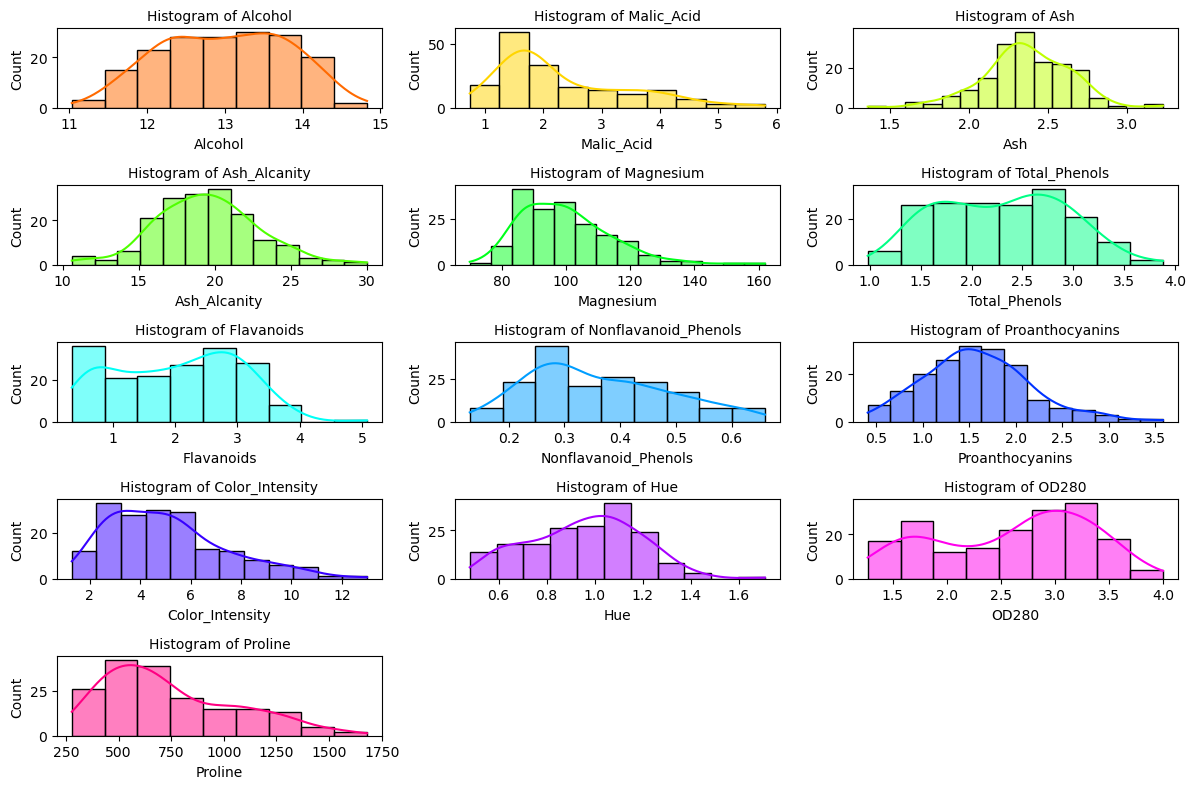

In [7]:
# Plot histograms for wine data
plot_histograms(wine_data)

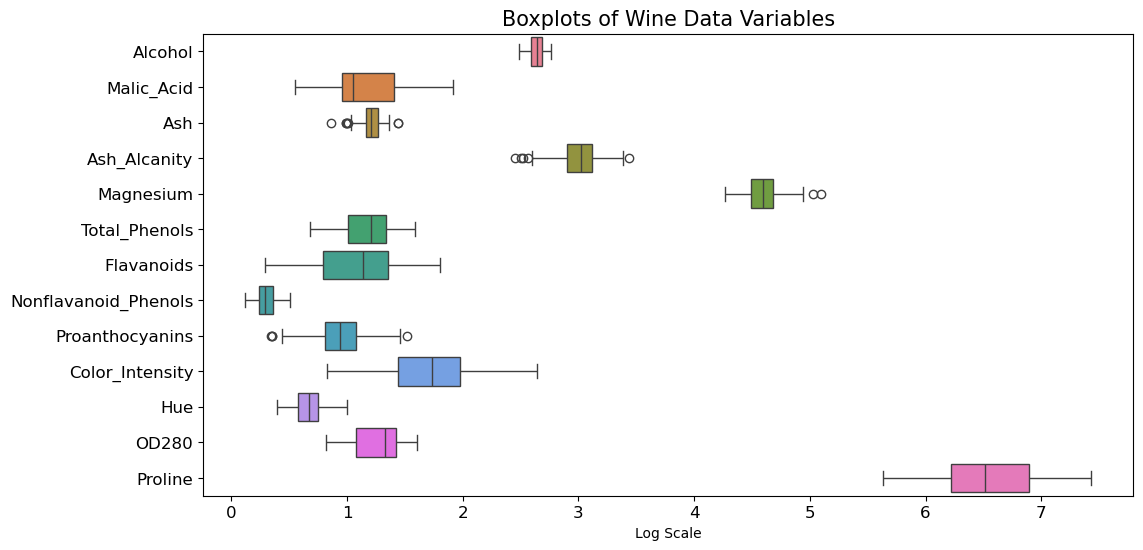

In [8]:
# Plot boxplots for wine data
plot_boxplots(wine_data)


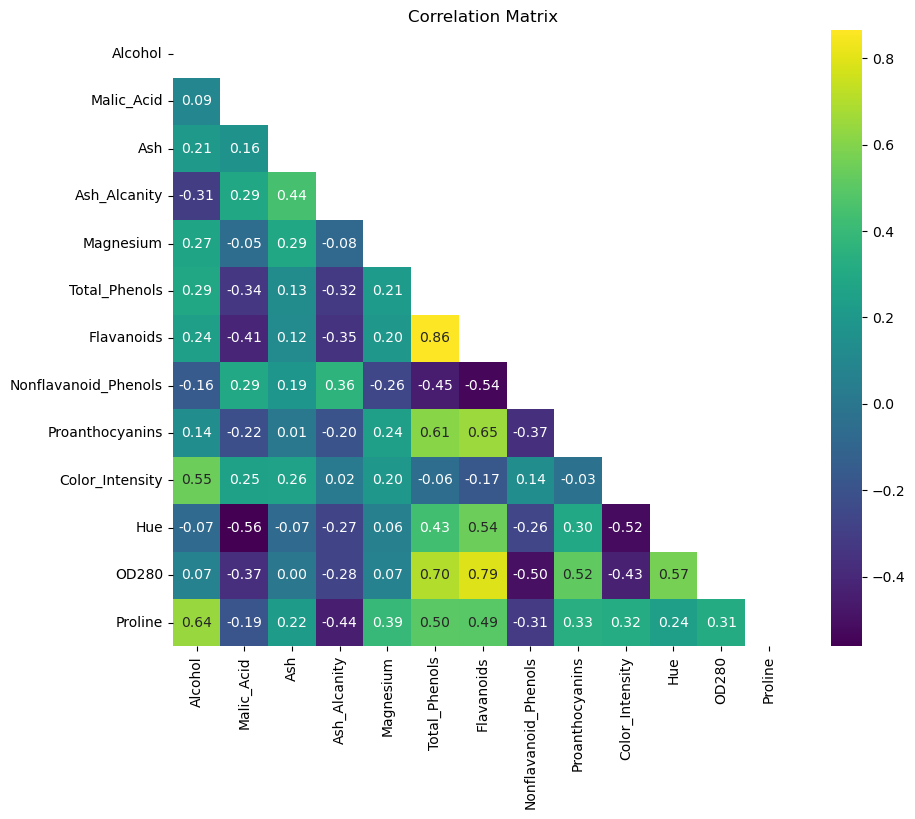

In [9]:
# Plot correlation matrix for wine data
plot_correlation_matrix(wine_data)


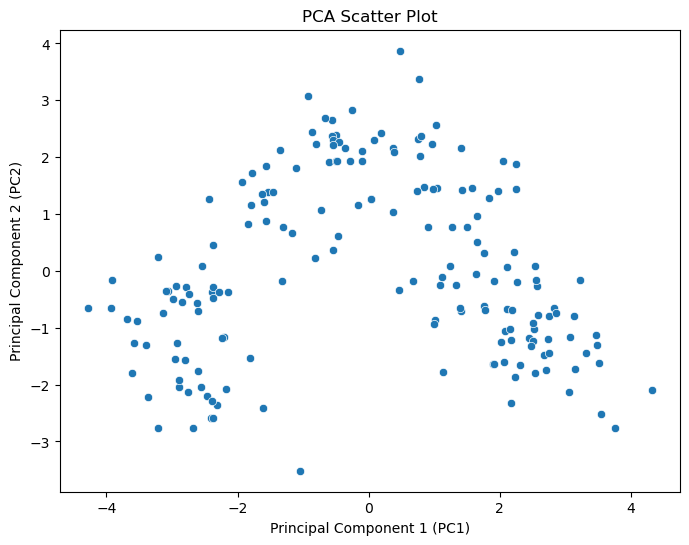

In [10]:

# Perform PCA on wine data
perform_pca(wine_data)


  File "C:\Users\ammar\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


2 Clusters - Silhouette Score: 0.4649
3 Clusters - Silhouette Score: 0.5611
4 Clusters - Silhouette Score: 0.4914
5 Clusters - Silhouette Score: 0.4391
6 Clusters - Silhouette Score: 0.4334
7 Clusters - Silhouette Score: 0.4222
8 Clusters - Silhouette Score: 0.4072
9 Clusters - Silhouette Score: 0.3994
10 Clusters - Silhouette Score: 0.4016
Best Number of Clusters: 3 (Silhouette Score: 0.5611)


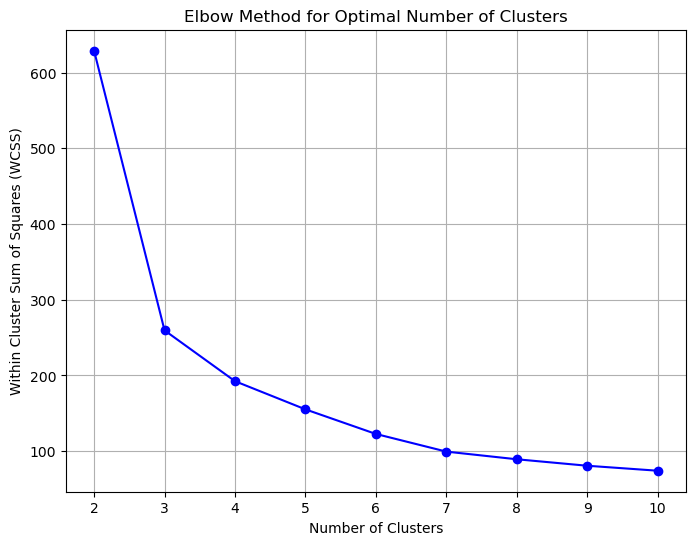

In [11]:
#create elbow plow and silhouette scores
find_cluster(wine_data)

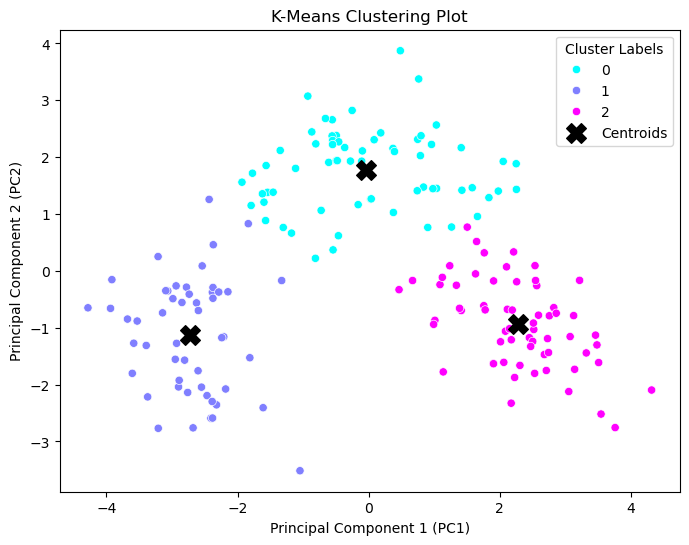

In [12]:

# Perform K-Means clustering on wine data
perform_kmeans(wine_data)

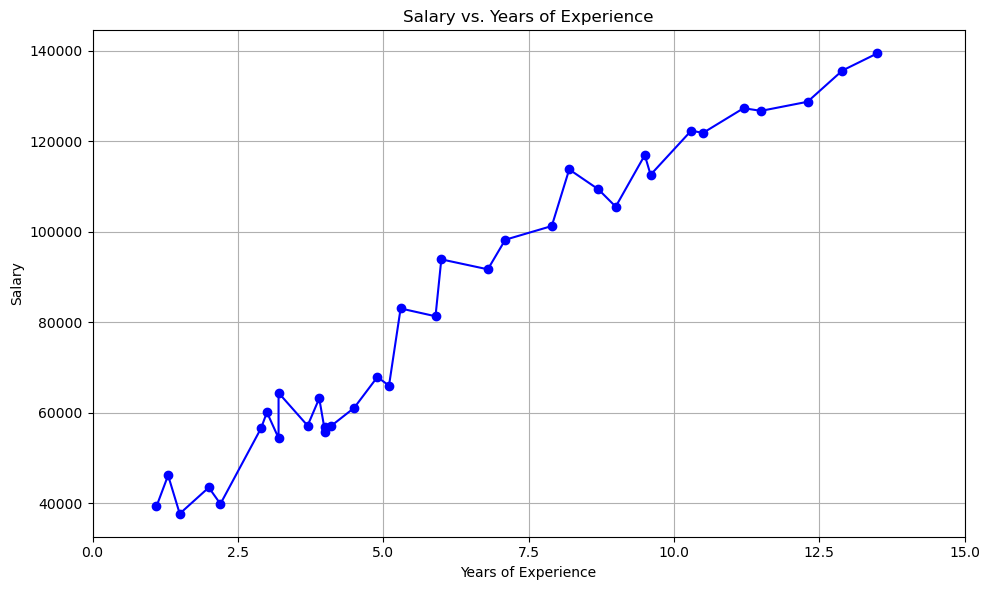

In [13]:
#create line plot for the data
line_plot(salary_data)

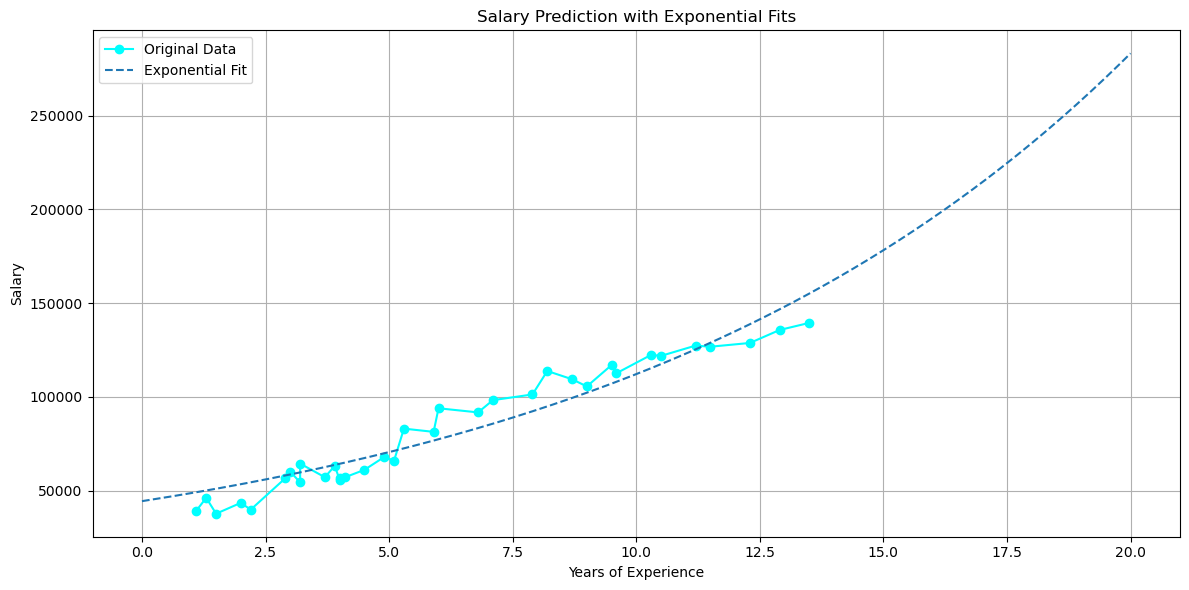

In [14]:
exponential_fit(salary_data)

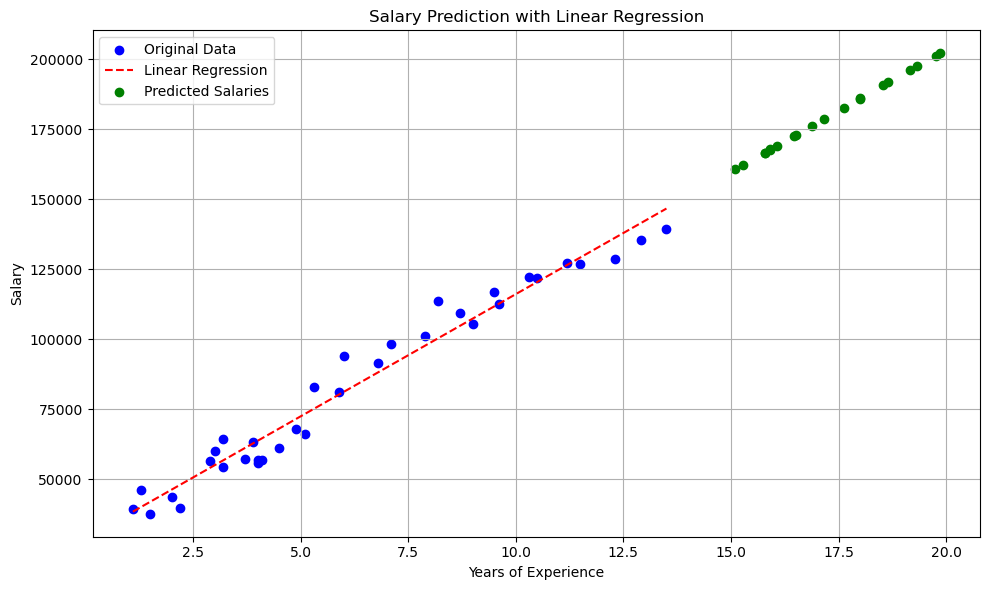

In [15]:
# Perform linear regression on salary data
perform_linear_regression(salary_data)